## MAIN

In [1]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd

# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 20.0 #4.3#20.0                          # simulation time 
n_sim = ceil(t_sim/t_step)                      # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.0 # 0.2

# -- Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

# -- set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**3# 10**7
params['lambda_g'] = 100#300# 100
params['ulim'] = 5

# -- create controller    
controller = DeePC(params,constr_u = False)
# controller.create_Hankel_check()

# -- offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

# -- Simulation setup for initial state  
x0 = np.array([[0],[0],[0]])
t_step = 0.1
t_sim = 3.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step > Tini + N + iter - 1
x = x0 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((p,n_sim+1))
yData_ini[:,[0]] = x0
Tini = n

# ======== GROUSE ========
low_dimension_rank = 3*(3+5)+3                 # m*(Tini+Tf)+n
controller.create_U1(low_dimension_rank)
GROUSE_ENABLE = False
step_size = 0.01
grouse_iter = 20
u_obs = np.zeros((m*(Tini + params['N'] + grouse_iter - 1),1))
y_obs = np.zeros((p*(Tini + params['N'] + grouse_iter - 1),1))

# -- non LTI system
CHANGE_ENABLE = False
t_change = 5
A_0 = A[0,0]

# -- Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# -- Generate initial state
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y
        
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y    
    
# Simulation    
print("===== START SIMULATION =====")
x0 = xData_ini[:,-1]
y0 = yData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 10.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = y0

# ======== GROUSE DATA LOG ========
U_true = controller.create_U1(low_dimension_rank)
subspaceLog = np.empty((1,n_sim))
if GROUSE_ENABLE:
    U_predictor = controller.create_U1(low_dimension_rank)
else:
    U_predictor = controller.Hankel_PF


# -- Run simulation
for t in range(n_sim):  
    if CHANGE_ENABLE:   
        if t>= t_change/t_step:
            A[0,0] = A_0 + 0.2*np.log(t)
        
    # u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)

    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    # subspaceLog[0,[t]] = np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),'fro')
    subspaceLog[0,[t]] = 27 - (np.linalg.norm(U_true.T@U_predictor,'fro'))**2
    
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])
    
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u_vec    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y_vec    
    
    if GROUSE_ENABLE:
        for i in range(grouse_iter):
            # step_size_dim = np.exp(-i)*step_size
            step_size_dim = step_size
            u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
            y_temp = y_obs[p*(grouse_iter-i-1):y_obs.shape[0]-p*i,:]
            u_p = u_temp[:m*Tini,:]
            u_f = u_temp[m*Tini:,:]
            y_p = y_temp[:p*Tini,:]
            y_f = y_temp[p*Tini:,:]    
            v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
            v_unit = v_obs/np.linalg.norm(v_obs,2) 
            U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
    else:
        pass
print("Simulation Done!")


We are good to go!!
===== START SIMULATION =====


c:\Users\Jzeta\anaconda3\envs\ifaenv\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation Done!


### Plotter

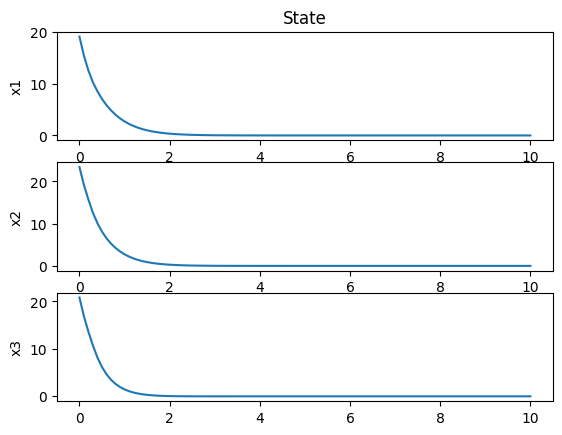

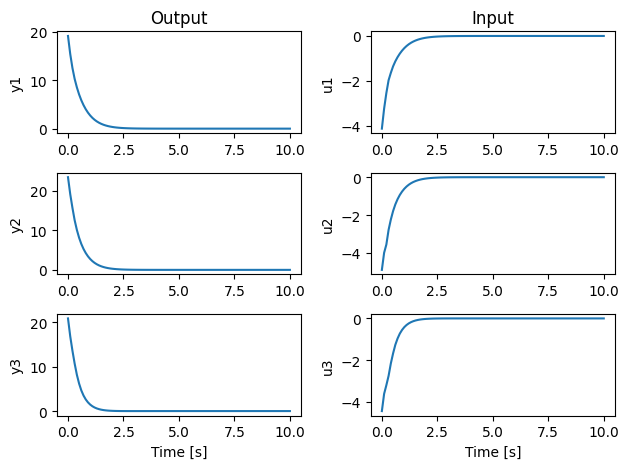

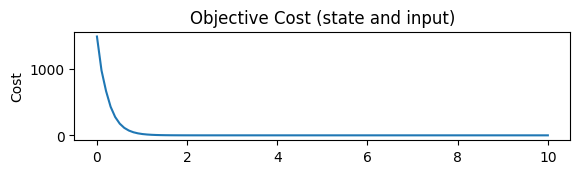

In [3]:
# Plot state evolution    
x_plot = plt.figure(0)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('x1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('x2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('x3')

# Plot input output evolution    
fig, axs = plt.subplots(3, 2)
time = np.linspace(0,t_sim,n_sim+1)
# -- output
axs[0, 0].plot(time,yLog[0,:])
axs[0, 0].set_title('Output')
axs[0, 0].set_ylabel('y1')
axs[1, 0].plot(time,yLog[1,:])
axs[1, 0].set_ylabel('y2')
axs[2, 0].plot(time,yLog[2,:])
axs[2, 0].set_ylabel('y3')
axs[2, 0].set_xlabel('Time [s]')
# -- input
time = np.linspace(0,t_sim,n_sim);
axs[0, 1].plot(time,uLog[0,:])
axs[0, 1].set_title('Input')
axs[0, 1].set_ylabel('u1')
axs[1, 1].plot(time,uLog[1,:])
axs[1, 1].set_ylabel('u2')
axs[2, 1].plot(time,uLog[2,:])
axs[2, 1].set_ylabel('u3')
axs[2, 1].set_xlabel('Time [s]')
plt.tight_layout()
if CHANGE_ENABLE:
    axs[0, 0].axvline(x=t_change, color='k', ls='--')
    axs[1, 0].axvline(x=t_change, color='k', ls='--')
    axs[2, 0].axvline(x=t_change, color='k', ls='--')
    axs[0, 1].axvline(x=t_change, color='k', ls='--')
    axs[1, 1].axvline(x=t_change, color='k', ls='--')
    axs[2, 1].axvline(x=t_change, color='k', ls='--')

# Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')
if CHANGE_ENABLE:
    plt.axvline(x=t_change, color='k', ls='--')

plt.show()

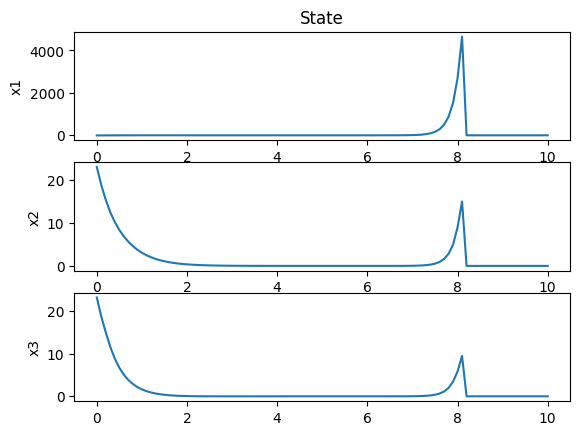

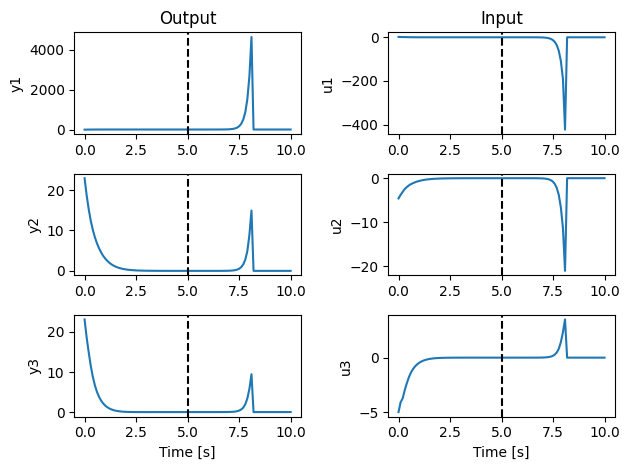

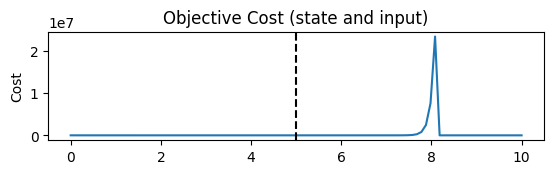

In [14]:
# Plot state evolution    
x_plot = plt.figure(0)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('x1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('x2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('x3')

# Plot input output evolution    
fig, axs = plt.subplots(3, 2)
time = np.linspace(0,t_sim,n_sim+1)
# -- output
axs[0, 0].plot(time,yLog[0,:])
axs[0, 0].set_title('Output')
axs[0, 0].set_ylabel('y1')
axs[1, 0].plot(time,yLog[1,:])
axs[1, 0].set_ylabel('y2')
axs[2, 0].plot(time,yLog[2,:])
axs[2, 0].set_ylabel('y3')
axs[2, 0].set_xlabel('Time [s]')
# -- input
time = np.linspace(0,t_sim,n_sim);
axs[0, 1].plot(time,uLog[0,:])
axs[0, 1].set_title('Input')
axs[0, 1].set_ylabel('u1')
axs[1, 1].plot(time,uLog[1,:])
axs[1, 1].set_ylabel('u2')
axs[2, 1].plot(time,uLog[2,:])
axs[2, 1].set_ylabel('u3')
axs[2, 1].set_xlabel('Time [s]')
plt.tight_layout()
if CHANGE_ENABLE:
    axs[0, 0].axvline(x=t_change, color='k', ls='--')
    axs[1, 0].axvline(x=t_change, color='k', ls='--')
    axs[2, 0].axvline(x=t_change, color='k', ls='--')
    axs[0, 1].axvline(x=t_change, color='k', ls='--')
    axs[1, 1].axvline(x=t_change, color='k', ls='--')
    axs[2, 1].axvline(x=t_change, color='k', ls='--')

# Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')
if CHANGE_ENABLE:
    plt.axvline(x=t_change, color='k', ls='--')

plt.show()

In [ ]:
# Plot subspace tracking  
sst_plot = plt.figure(4)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,subspaceLog[0,:])
plt.ylabel('L-gap')
plt.title('L-gap')

## Slowly Varying Sytem

In [ ]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd

# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 10.7 #4.3#20.0                          # simulation time 
n_sim = ceil(t_sim/t_step)                      # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.0 # 0.2

# -- non LTI system
CHANGE_ENABLE = False
t_change = 3
A_0 = A[0,0]

# -- Collect data
for t in range(n_sim):
    if CHANGE_ENABLE:   
        # A[0,0] = A_0 + 0.1*np.log(t+1)
        A[0,0] = A_0
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

# -- set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**5#10**3# 10**7
params['lambda_g'] = 100#100#300# 100
params['ulim'] = 5

# params['uData'] = uData[:,:50+7]
# params['yData'] = yData[:,1:50+8] 

# -- create controller    
controller = DeePC(params,constr_u = False)
# controller.create_Hankel_check()

# -- offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

# -- Simulation setup for initial state  
x0 = np.array([[0],[0],[0]])
t_step = 0.1
t_sim = 3.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step > Tini + N + iter - 1
x = x0 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((p,n_sim+1))
yData_ini[:,[0]] = x0
Tini = n

# ======== GROUSE ========
low_dimension_rank = 3*(3+5)+3                 # m*(Tini+Tf)+n
controller.create_U1(low_dimension_rank)
GROUSE_ENABLE = True
step_size = 0.01
grouse_iter = 20
u_obs = np.zeros((m*(Tini + params['N'] + grouse_iter - 1),1))
y_obs = np.zeros((p*(Tini + params['N'] + grouse_iter - 1),1))

# -- Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# -- Generate initial state
for t in range(n_sim):
    if CHANGE_ENABLE:   
        # A[0,0] = A_0 + 0.5*np.log(t+1)
        A[0,0] = A_0
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y
        
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y    

# -- obs vector for tuning
u_obs_ini = u_obs
y_obs_ini = y_obs

# -- Simulation    
print("===== START SIMULATION =====")
x0 = xData_ini[:,-1]
y0 = yData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 15.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = y0

# ======== GROUSE DATA LOG ========
U_true = controller.create_U1(low_dimension_rank)
subspaceLog = np.empty((1,n_sim))
if GROUSE_ENABLE:
    U_predictor = controller.create_U1(low_dimension_rank)
else:
    U_predictor = controller.Hankel_PF
    # U_predictor = controller.create_U1(low_dimension_rank)
    # U_predictor = controller.create_U1(low_dimension_rank)


# -- Run simulation
for t in range(n_sim):  
    if CHANGE_ENABLE:   
        if t>=t_change/t_step:
            # A[0,0] = A_0 + 0.1*np.log(t+1)
            A[0,0] = A_0 + 1.0*np.sin(0.02*(t-t_change/t_step+1))
            A[0,0] = A_0
            # print(A[0,0])
    try:
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
    except:
        print("Infeasible")
        print(t)
        break
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    # subspaceLog[0,[t]] = np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),'fro')
    subspaceLog[0,[t]] = 27 - (np.linalg.norm(U_true.T@U_predictor,'fro'))**2
    
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])
    
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u_vec    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y_vec    
    
    if GROUSE_ENABLE:
        for i in range(grouse_iter):
            # step_size_dim = np.exp(-i)*step_size
            step_size_dim = step_size
            u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
            y_temp = y_obs[p*(grouse_iter-i-1):y_obs.shape[0]-p*i,:]
            u_p = u_temp[:m*Tini,:]
            u_f = u_temp[m*Tini:,:]
            y_p = y_temp[:p*Tini,:]
            y_f = y_temp[p*Tini:,:]    
            v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
            v_unit = v_obs/np.linalg.norm(v_obs,2) 
            U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
    else:
        pass
print("Simulation Done!")
print(sum(costLog[0,:]))


We are good to go!!
===== START SIMULATION =====
Simulation Done!


### Plot

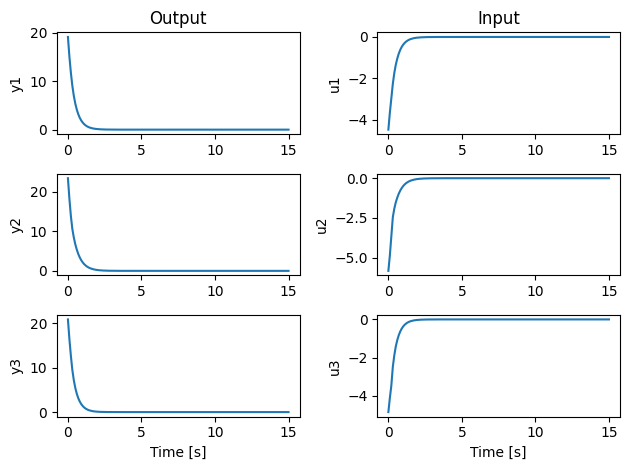

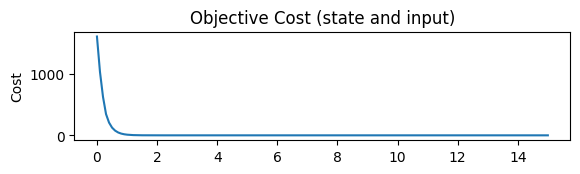

4124.956401450959


In [22]:
# -- Plot state evolution    
# x_plot = plt.figure(0)
# time = np.linspace(0,t_sim,n_sim+1)

# plt.subplot(311)
# plt.plot(time,xLog[0,:])
# plt.ylabel('x1')
# plt.title('State')

# plt.subplot(312)
# plt.plot(time,xLog[1,:])   
# plt.ylabel('x2')

# plt.subplot(313)
# plt.plot(time,xLog[2,:])
# plt.ylabel('x3')

# -- Plot input output evolution    
fig, axs = plt.subplots(3, 2)
time = np.linspace(0,t_sim,n_sim+1)
# -- output
axs[0, 0].plot(time,yLog[0,:])
axs[0, 0].set_title('Output')
axs[0, 0].set_ylabel('y1')
axs[1, 0].plot(time,yLog[1,:])
axs[1, 0].set_ylabel('y2')
axs[2, 0].plot(time,yLog[2,:])
axs[2, 0].set_ylabel('y3')
axs[2, 0].set_xlabel('Time [s]')
# -- input
time = np.linspace(0,t_sim,n_sim);
axs[0, 1].plot(time,uLog[0,:])
axs[0, 1].set_title('Input')
axs[0, 1].set_ylabel('u1')
axs[1, 1].plot(time,uLog[1,:])
axs[1, 1].set_ylabel('u2')
axs[2, 1].plot(time,uLog[2,:])
axs[2, 1].set_ylabel('u3')
axs[2, 1].set_xlabel('Time [s]')
plt.tight_layout()
if CHANGE_ENABLE:
    axs[0, 0].axvline(x=t_change, color='k', ls='--')
    axs[1, 0].axvline(x=t_change, color='k', ls='--')
    axs[2, 0].axvline(x=t_change, color='k', ls='--')
    axs[0, 1].axvline(x=t_change, color='k', ls='--')
    axs[1, 1].axvline(x=t_change, color='k', ls='--')
    axs[2, 1].axvline(x=t_change, color='k', ls='--')

# -- Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')
if CHANGE_ENABLE:
    plt.axvline(x=t_change, color='k', ls='--')

# -- Plot subspace tracking  
# sst_plot = plt.figure(4)
# time = np.linspace(0,t_sim,n_sim);
# plt.subplot(311)
# plt.plot(time,subspaceLog[0,:])
# plt.ylabel('L-gap')
# plt.title('L-gap')


plt.show()
print(sum(costLog[0,:]))

### ..

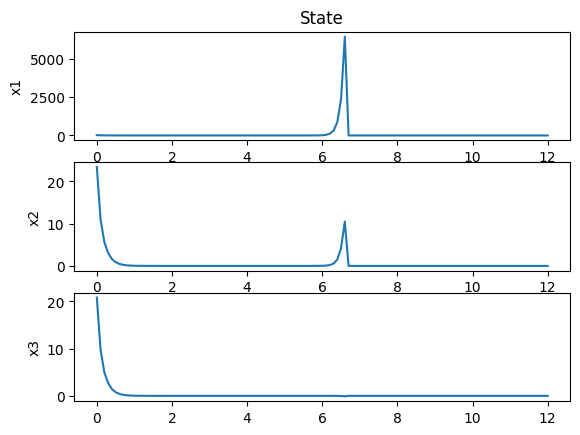

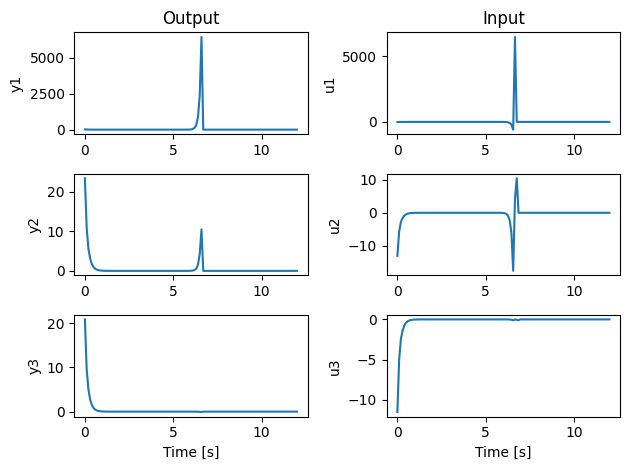

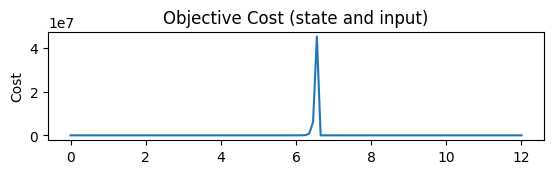

52098469.497999854


In [104]:
# Plot state evolution    
x_plot = plt.figure(0)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('x1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('x2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('x3')

# Plot input output evolution    
fig, axs = plt.subplots(3, 2)
time = np.linspace(0,t_sim,n_sim+1)
# -- output
axs[0, 0].plot(time,yLog[0,:])
axs[0, 0].set_title('Output')
axs[0, 0].set_ylabel('y1')
axs[1, 0].plot(time,yLog[1,:])
axs[1, 0].set_ylabel('y2')
axs[2, 0].plot(time,yLog[2,:])
axs[2, 0].set_ylabel('y3')
axs[2, 0].set_xlabel('Time [s]')
# -- input
time = np.linspace(0,t_sim,n_sim);
axs[0, 1].plot(time,uLog[0,:])
axs[0, 1].set_title('Input')
axs[0, 1].set_ylabel('u1')
axs[1, 1].plot(time,uLog[1,:])
axs[1, 1].set_ylabel('u2')
axs[2, 1].plot(time,uLog[2,:])
axs[2, 1].set_ylabel('u3')
axs[2, 1].set_xlabel('Time [s]')
plt.tight_layout()
# if CHANGE_ENABLE:
#     axs[0, 0].axvline(x=t_change, color='k', ls='--')
#     axs[1, 0].axvline(x=t_change, color='k', ls='--')
#     axs[2, 0].axvline(x=t_change, color='k', ls='--')
#     axs[0, 1].axvline(x=t_change, color='k', ls='--')
#     axs[1, 1].axvline(x=t_change, color='k', ls='--')
#     axs[2, 1].axvline(x=t_change, color='k', ls='--')

# Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')
# if CHANGE_ENABLE:
#     plt.axvline(x=t_change, color='k', ls='--')

plt.show()
print(sum(costLog[0,:]))

### debugger

In [7]:
A[0,0]

1.01

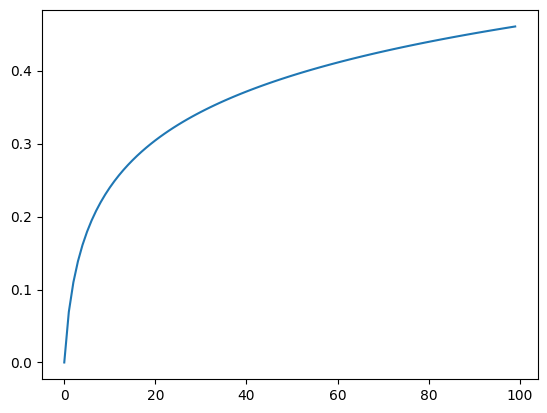

In [7]:
t0 = 0
tLog = np.zeros((1,100))
for t in range(100):
    tLog[:,[t]] = t0 + 0.1*np.log(t+1)
plt.plot(tLog[0,:])
plt.show()
    

## Tuning

### Vanila

#### Iterate for lambda y

=== ITERATION: 0
Lambda_slack: 1000.0
Cost: 974159.5445644798
=== ITERATION: 1
Lambda_slack: 1930.6977288832495
Cost: 61583.65690948145
=== ITERATION: 2
Lambda_slack: 3727.593720314938
Cost: 17586.810214527482
=== ITERATION: 3
Lambda_slack: 7196.856730011521
Cost: 11132.249930209116
=== ITERATION: 4
Lambda_slack: 13894.95494373136
Cost: 9408.525892572628
=== ITERATION: 5
Lambda_slack: 26826.957952797275
Cost: 8777.361018020541
=== ITERATION: 6
Lambda_slack: 51794.74679231213
Cost: 8504.578997066486
=== ITERATION: 7
Lambda_slack: 100000.0
Cost: 8376.01375126797


<Figure size 640x480 with 0 Axes>

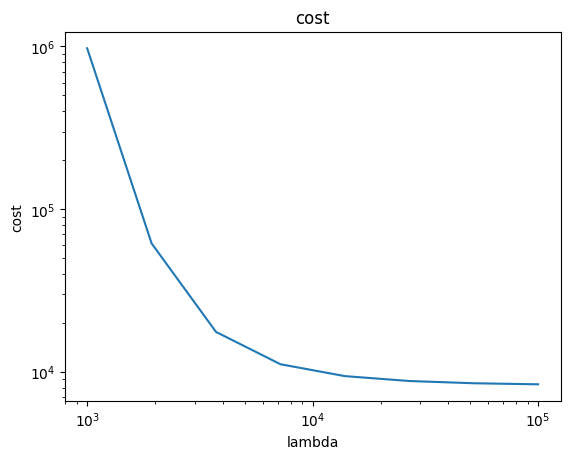

In [11]:
lambda_List = np.geomspace(10**2, 10**5, num=8)
t_step = 0.1
t_sim = 12.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_g'] = 50

# run simulation
for i in range(len(lambda_List)):
    params['lambda_slack'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    U_predictor = controller.create_U1(low_dimension_rank)
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 12.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0
    
    for t in range(n_sim):
        if CHANGE_ENABLE:   
            A[0,0] = A_0 + 0.1*np.log(t+1)
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
            
    print("=== ITERATION: " + str(i))
    print("Lambda_slack: " + str(params['lambda_slack']))
    print("Cost: " + str(np.sum(costLog)))    
    sumcostLog[0,[i]] = np.sum(costLog)

y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()

#### Iterate for lambda g

In [10]:
lambda_List = [20,50,100,200,300,500,700]
t_step = 0.1
t_sim = 12.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_slack'] = 10**3
print("==== Lambda_g tuning ====")

# run simulation
for i in range(len(lambda_List)):
    params['lambda_g'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()  
    U_predictor = controller.create_U1(low_dimension_rank)   
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 12.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0

    for t in range(n_sim):
        if CHANGE_ENABLE:   
            A[0,0] = A_0 + 0.1*np.log(t+1)
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
        
    print("=== ITERATION: " + str(i))
    print("Lambda_g: " + str(params['lambda_g']))
    print("Cost: " + str(np.sum(costLog)))

    sumcostLog[0,[i]] = np.sum(costLog)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()


==== Lambda_g tuning ====
=== ITERATION: 0
Lambda_g: 20
Cost: 1372036.2747663157
=== ITERATION: 1
Lambda_g: 50
Cost: 974159.5445644798
=== ITERATION: 2
Lambda_g: 100
Cost: 45186696.52752587


TypeError: 'NoneType' object is not subscriptable

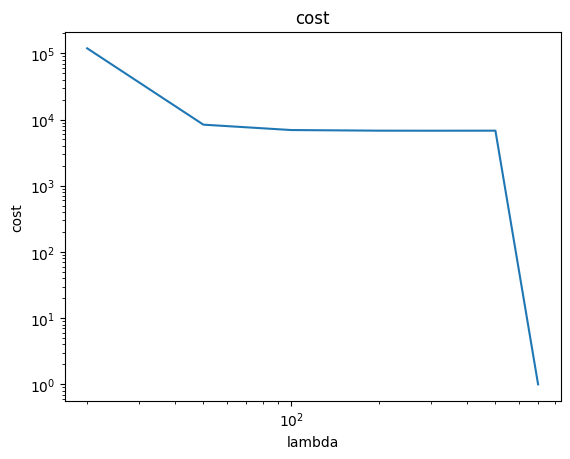

In [62]:
# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()

### GROUSE

#### Iterate for lambda y with GROUSE

==== Lambda_y tuning ====
=== ITERATION: 0
Lambda_slack: 300.0
Cost: 13158.669464691713
=== ITERATION: 1
Lambda_slack: 411.56589411488574
Cost: 5065.120534579098
=== ITERATION: 2
Lambda_slack: 564.621617328617
Cost: 5247.308275444799
=== ITERATION: 3
Lambda_slack: 774.5966692414836
Cost: 5479.4783716293505
=== ITERATION: 4
Lambda_slack: 1062.6585691826117
Cost: 5696.904878625441
=== ITERATION: 5
Lambda_slack: 1457.8467472149553
Cost: 5882.562170468597
=== ITERATION: 6
Lambda_slack: 2000.0
Cost: 6033.617693647406


<Figure size 640x480 with 0 Axes>

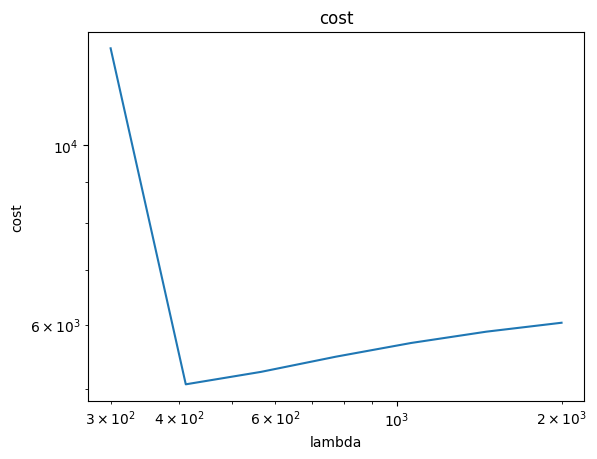

In [48]:
lambda_List = np.geomspace(3*10**2, 2*10**3, num=7)
# lambda_List = [10**3]
t_step = 0.1
t_sim = 12.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_g'] = 100
print("==== Lambda_y tuning ====")


# run simulation
for i in range(len(lambda_List)):
    params['lambda_slack'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    U_predictor = controller.create_U1(low_dimension_rank)
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 12.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0
    
    u_obs = u_obs_ini
    y_obs = y_obs_ini
    
    for t in range(n_sim):
        if CHANGE_ENABLE:   
            A[0,0] = A_0 + 0.1*np.log(t+1)
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
        
        # update u_obs, y_obs
        u_obs = np.roll(u_obs,-Tini)
        u_obs[-Tini:,:] = u_vec    
        y_obs = np.roll(y_obs,-Tini)
        y_obs[-Tini:,:] = y_vec    
        
        if GROUSE_ENABLE:
            for ii in range(grouse_iter):
                # step_size_dim = np.exp(-i)*step_size
                step_size_dim = step_size
                u_temp = u_obs[m*(grouse_iter-ii-1):u_obs.shape[0]-m*ii,:]
                y_temp = y_obs[p*(grouse_iter-ii-1):y_obs.shape[0]-p*ii,:]
                u_p = u_temp[:m*Tini,:]
                u_f = u_temp[m*Tini:,:]
                y_p = y_temp[:p*Tini,:]
                y_f = y_temp[p*Tini:,:]    
                v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
                v_unit = v_obs/np.linalg.norm(v_obs,2) 
                U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
        else:
            pass
        
    print("=== ITERATION: " + str(i))
    print("Lambda_slack: " + str(params['lambda_slack']))
    print("Cost: " + str(np.sum(costLog)))  
    sumcostLog[0,[i]] = np.sum(costLog)

y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()

#### Iterate for lambda g with GROUSE

==== Lambda_y tuning ====
=== ITERATION: 0
Lambda_g: 5
Cost: 678678.3073136067
=== ITERATION: 1
Lambda_g: 10
Cost: 5504.245677507069
=== ITERATION: 2
Lambda_g: 20
Cost: 5798.70243597941
=== ITERATION: 3
Lambda_g: 50
Cost: 5894.488826282893
=== ITERATION: 4
Lambda_g: 100
Cost: 5657.294509271053
=== ITERATION: 5
Lambda_g: 200
Cost: 5206.767037700397
=== ITERATION: 6
Lambda_g: 300
Cost: 5137.943253638077
=== ITERATION: 7
Lambda_g: 400
Cost: 8210823.849689262


<Figure size 640x480 with 0 Axes>

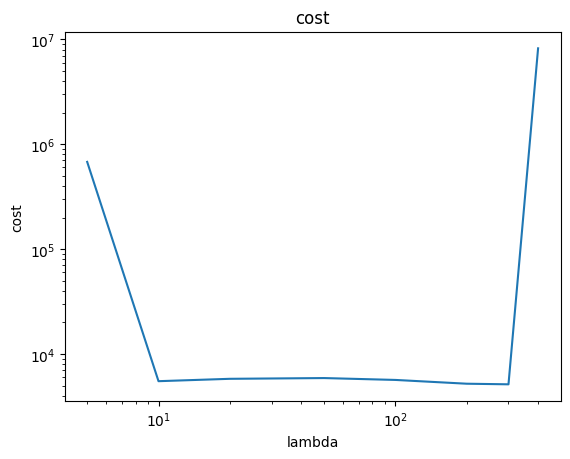

In [32]:
lambda_List = [5,10,20,50,100,200,300,400]
t_step = 0.1
t_sim = 12.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_slack'] = 10**3
print("==== Lambda_y tuning ====")


# run simulation
for i in range(len(lambda_List)):
    params['lambda_g'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    U_predictor = controller.create_U1(low_dimension_rank)
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 12.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0
    
    u_obs = u_obs_ini
    y_obs = y_obs_ini
    
    for t in range(n_sim):
        if CHANGE_ENABLE:   
            A[0,0] = A_0 + 0.1*np.log(t+1)
        u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
        
        # update u_obs, y_obs
        u_obs = np.roll(u_obs,-Tini)
        u_obs[-Tini:,:] = u_vec    
        y_obs = np.roll(y_obs,-Tini)
        y_obs[-Tini:,:] = y_vec    
        
        if GROUSE_ENABLE:
            for ii in range(grouse_iter):
                # step_size_dim = np.exp(-i)*step_size
                step_size_dim = step_size
                u_temp = u_obs[m*(grouse_iter-ii-1):u_obs.shape[0]-m*ii,:]
                y_temp = y_obs[p*(grouse_iter-ii-1):y_obs.shape[0]-p*ii,:]
                u_p = u_temp[:m*Tini,:]
                u_f = u_temp[m*Tini:,:]
                y_p = y_temp[:p*Tini,:]
                y_f = y_temp[p*Tini:,:]    
                v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
                v_unit = v_obs/np.linalg.norm(v_obs,2) 
                U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
        else:
            pass
        
    print("=== ITERATION: " + str(i))
    print("Lambda_g: " + str(params['lambda_g']))
    print("Cost: " + str(np.sum(costLog)))  
    sumcostLog[0,[i]] = np.sum(costLog)

y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()

## Hyper Parameter Tuning

### Code demo

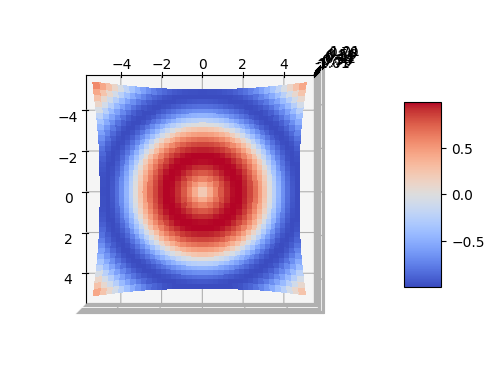

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(elev=90, azim=0)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

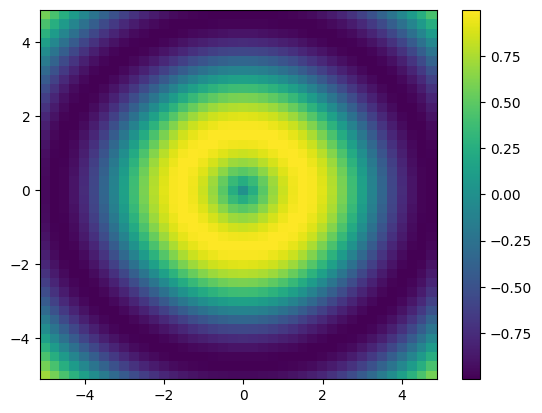

In [143]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

plt.pcolor(X, Y, Z)
plt.colorbar()
plt.show()

In [149]:
Z.shape

(6, 6)

In [151]:
lambda_g_List

[20, 50, 100, 200, 300, 500]

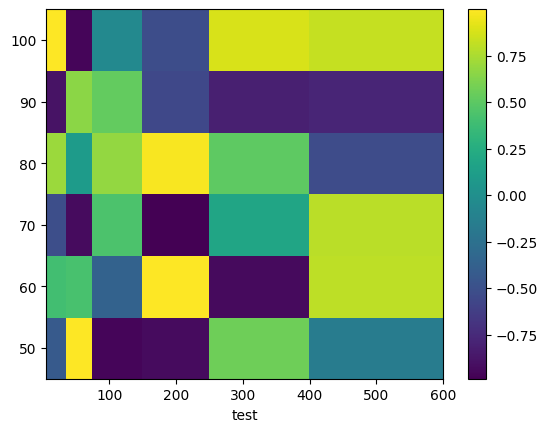

In [152]:
lambda_g_List = np.array([20,50,100,200,300,500])
dimension_List = np.array([50,60,70,80,90,100])
X, Y = np.meshgrid(lambda_g_List, dimension_List)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
plt.xlabel("test")
plt.pcolor(X, Y, Z)
plt.colorbar()
plt.show()

In [154]:
Z.shape[0]

6

In [158]:
lambda_g_List.shape

(6,)

### DeePC

In [36]:
lambda_g_List = np.array([20,50,100,200,300,500])
dimension_List = np.array([50,60,70,80,90,100])
lambda_g_List = np.array([20,50,100])
dimension_List = np.array([50,60,100])
t_step = 0.1
t_sim = 12.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcost_preLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
sumcost_postLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
sumcostLog = np.empty((lambda_g_List.shape[0],dimension_List.shape[0]))
params['lambda_slack'] = 10**5
# -- non LTI system
CHANGE_ENABLE = True
t_change = 3
A_0 = A[0,0]
GROUSE_ENABLE = False
INFEASIBLE = False
count = 1

print("==== DeePC Hyper Parameter Tuning ====")
# -- run simulation
for dim in range(dimension_List.shape[0]):
    params['uData'] = uData[:,:dimension_List[dim]+7]
    params['yData'] = yData[:,1:dimension_List[dim]+8] 
    for i in range(lambda_g_List.shape[0]):
        params['lambda_g'] = lambda_g_List[i]
        print(">>> ITERATION: " + str(count))
        print("Lambda_g: " + str(params['lambda_g']))
        print("Dimension: " + str(dimension_List[dim]))
        # create controller    
        controller = DeePC(params) 
        controller.create_Hankel()  
        U_predictor = controller.Hankel_PF
        # init new log
        x0 = xData_ini[:,-1]
        y0 = yData_ini[:,-1]
        u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
        y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
        t_step = 0.1
        t_sim = 12.0;                                  # simulation time
        n_sim = ceil(t_sim/t_step)                     # Number of simulation step
        x = x0.reshape(m, 1)
        xLog = np.zeros((n,n_sim+1))
        xLog[:,0] = x0
        uLog = np.empty((m,n_sim))
        costLog = np.empty((1,n_sim))
        yLog = np.zeros((n,n_sim+1))
        yLog[:,0] = y0

        for t in range(n_sim):
            if CHANGE_ENABLE:   
                if t>=int(t_change/t_step):
                    # A[0,0] = A_0 + 1.0*np.sin(0.02*(t-t_change/t_step+1))
                    A[0,0] = A_0
            try:
                u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)
            except:
                print("INFEASIBLE!!")
                sumcost_postLog[i,dim] = np.inf
                sumcostLog[i,dim] = np.inf
                INFEASIBLE = True
                break
            x = A@x+B@u    
            w = np.random.normal(mu, sigma, size=(n, 1))
            y = C@x+w
            u_vec = np.reshape(u,(-1, 1))
            x_vec = np.reshape(x,(-1, 1))
            y_vec = np.reshape(y,(-1, 1))
            cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
            uLog[:,[t]] = u_vec
            xLog[:,[t+1]] = x_vec
            yLog[:,[t+1]] = y_vec
            costLog[0,[t]] = cost
            u_ini = np.block([[u_ini[n:]],[u_vec]])
            y_ini = np.block([[y_ini[n:]],[y_vec]])
        
        sumcost_preLog[i,dim] = np.sum(costLog[:int(t_change/t_step)])
        if not INFEASIBLE:
            sumcost_postLog[i,dim] = np.sum(costLog[int(t_change/t_step):])
            sumcostLog[i,dim] = np.sum(costLog)
            INFEASIBLE = False
        INFEASIBLE = False            
        print("Cost: " + str(sumcostLog[i,dim]))
        print(controller.Hankel_PF.shape)
        count+=1



==== DeePC Hyper Parameter Tuning ====
>>> ITERATION: 1
Lambda_g: 20
Dimension: 50


c:\Users\Jzeta\anaconda3\envs\ifaenv\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cost: 4550.321026893182
(48, 50)
>>> ITERATION: 2
Lambda_g: 50
Dimension: 50
Cost: 5217.06119218244
(48, 50)
>>> ITERATION: 3
Lambda_g: 100
Dimension: 50
Cost: 6214.6059873554095
(48, 50)
>>> ITERATION: 4
Lambda_g: 20
Dimension: 60
Cost: 4375.422586026411
(48, 60)
>>> ITERATION: 5
Lambda_g: 50
Dimension: 60
Cost: 4807.699753926262
(48, 60)
>>> ITERATION: 6
Lambda_g: 100
Dimension: 60
Cost: 5401.269588245332
(48, 60)
>>> ITERATION: 7
Lambda_g: 20
Dimension: 100
Cost: 4124.956401450954
(48, 100)
>>> ITERATION: 8
Lambda_g: 50
Dimension: 100
Cost: 4268.287918430499
(48, 100)
>>> ITERATION: 9
Lambda_g: 100
Dimension: 100
INFEASIBLE!!
Cost: inf
(48, 100)


### Color Map

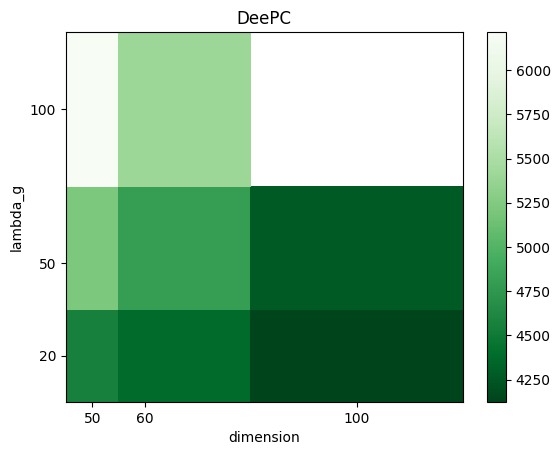

In [40]:
X, Y = np.meshgrid(dimension_List,lambda_g_List)
Z = sumcostLog
plt.title("DeePC")
plt.ylabel("lambda_g")
plt.yticks(lambda_g_List)
plt.xticks(dimension_List)
plt.xlabel("dimension")
plt.pcolor(X, Y, Z, cmap = 'Greens_r')
plt.colorbar()
plt.show()

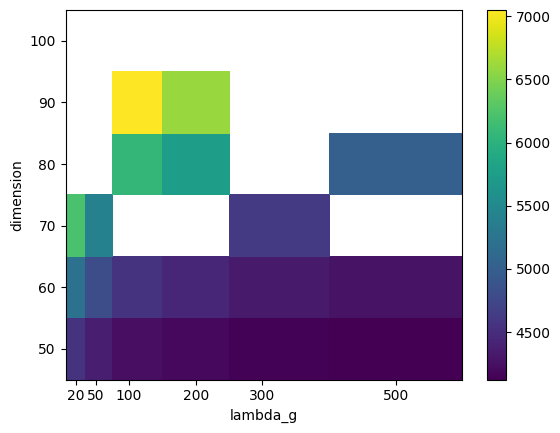

In [9]:
X, Y = np.meshgrid(lambda_g_List, dimension_List)
Z = sumcostLog
plt.xlabel("lambda_g")
plt.xticks(lambda_g_List)
plt.yticks(dimension_List)
plt.ylabel("dimension")
plt.pcolor(X, Y, Z)
plt.colorbar()
plt.show()


In [181]:
sumcostLog.shape

(2, 2)

In [178]:
t_change/t_step

30.0

In [176]:
sumcost_preLog[i,dim]

132.6875

In [173]:
sumcost_preLog

array([[-132.6875,   -4.    ],
       [ 132.6875,   14.    ]])

In [174]:
sumcost_preLog[0,0]

-132.6875

### DeePC + GROUSE

In [ ]:
###